In [263]:
using ITensors, ITensorMPS, Plots
using Plots.PlotMeasures

In [264]:
N = 30 #Number of lattice sites per dimension
d = 1 #Number of spatial dimensions
dx = 1 #Lattice spacing

n_0 = round(Int, ((N-1)/2)) #Index of thepoint at the center of the lattice.
dp = (12.5)/(N*dx) #Discrete change in momentum

Delta = 0
mass = 2.3
p_i = [-(n_0*dp)+(s-Delta)*dp for s in 0:N-1]
om_i = [sqrt(((2/dx)*sin(p_i[i]*(dx/2)))^2 + mass^2) for i in 1:N]

30-element Vector{Float64}:
 2.3428565987860686
 2.448475632690609
 2.592812301165193
 2.747252336629003
 2.8858397825882927
 2.9884977354314857
 3.0419316247118635
 3.0396745277043493
 2.9819938348517536
 2.875896323575759
 2.735223408796574
 2.580572664198678
 2.4382730593257773
 ⋮
 2.735223408796574
 2.8758963235757586
 2.9819938348517536
 3.0396745277043493
 3.0419316247118635
 2.988497735431486
 2.8858397825882927
 2.747252336629003
 2.5928123011651936
 2.448475632690609
 2.3428565987860686
 2.3002393709244697

In [265]:
H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
for i in 1:N
    H += (om_i[i]*dp)/(2pi), "a", i, "a†", i
    H += (om_i[i]*dp)/(2pi)*(1/2)*(2pi/dp), "Id", i
end

sites = siteinds("Boson", N; dim=9) #Create ITensor "SFT" sites

30-element Vector{Index{Int64}}:
 (dim=9|id=479|"Boson,Site,n=1")
 (dim=9|id=658|"Boson,Site,n=2")
 (dim=9|id=949|"Boson,Site,n=3")
 (dim=9|id=791|"Boson,Site,n=4")
 (dim=9|id=672|"Boson,Site,n=5")
 (dim=9|id=509|"Boson,Site,n=6")
 (dim=9|id=214|"Boson,Site,n=7")
 (dim=9|id=504|"Boson,Site,n=8")
 (dim=9|id=1|"Boson,Site,n=9")
 (dim=9|id=756|"Boson,Site,n=10")
 (dim=9|id=156|"Boson,Site,n=11")
 (dim=9|id=527|"Boson,Site,n=12")
 (dim=9|id=930|"Boson,Site,n=13")
 ⋮
 (dim=9|id=516|"Boson,Site,n=19")
 (dim=9|id=605|"Boson,Site,n=20")
 (dim=9|id=481|"Boson,Site,n=21")
 (dim=9|id=356|"Boson,Site,n=22")
 (dim=9|id=707|"Boson,Site,n=23")
 (dim=9|id=807|"Boson,Site,n=24")
 (dim=9|id=656|"Boson,Site,n=25")
 (dim=9|id=77|"Boson,Site,n=26")
 (dim=9|id=617|"Boson,Site,n=27")
 (dim=9|id=1|"Boson,Site,n=28")
 (dim=9|id=339|"Boson,Site,n=29")
 (dim=9|id=104|"Boson,Site,n=30")

In [266]:
function MakeState(excitation_dict)
    for i in keys(excitation_dict)
        if i > N
            error("excitation_dict contains an index that is greater than the number of sites in the lattice.")
        end
    end

    state = []
    for i in 1:N
        if haskey(excitation_dict, i)
            push!(state, excitation_dict[i])
        else
            push!(state, "0")
        end
    end

    return state
end

MakeState (generic function with 1 method)

In [267]:
gs_Dict = Dict() #Dictionary containing excitations (or lack thereof) in the ground state
psi_gs = MPS(sites, MakeState(gs_Dict)) #Ground State

MPS
[1] ((dim=9|id=479|"Boson,Site,n=1"), (dim=1|id=770|"Link,l=1"))
[2] ((dim=1|id=770|"Link,l=1"), (dim=9|id=658|"Boson,Site,n=2"), (dim=1|id=687|"Link,l=2"))
[3] ((dim=1|id=687|"Link,l=2"), (dim=9|id=949|"Boson,Site,n=3"), (dim=1|id=292|"Link,l=3"))
[4] ((dim=1|id=292|"Link,l=3"), (dim=9|id=791|"Boson,Site,n=4"), (dim=1|id=806|"Link,l=4"))
[5] ((dim=1|id=806|"Link,l=4"), (dim=9|id=672|"Boson,Site,n=5"), (dim=1|id=112|"Link,l=5"))
[6] ((dim=1|id=112|"Link,l=5"), (dim=9|id=509|"Boson,Site,n=6"), (dim=1|id=432|"Link,l=6"))
[7] ((dim=1|id=432|"Link,l=6"), (dim=9|id=214|"Boson,Site,n=7"), (dim=1|id=408|"Link,l=7"))
[8] ((dim=1|id=408|"Link,l=7"), (dim=9|id=504|"Boson,Site,n=8"), (dim=1|id=875|"Link,l=8"))
[9] ((dim=1|id=875|"Link,l=8"), (dim=9|id=1|"Boson,Site,n=9"), (dim=1|id=701|"Link,l=9"))
[10] ((dim=1|id=701|"Link,l=9"), (dim=9|id=756|"Boson,Site,n=10"), (dim=1|id=933|"Link,l=10"))
[11] ((dim=1|id=933|"Link,l=10"), (dim=9|id=156|"Boson,Site,n=11"), (dim=1|id=224|"Link,l=11"))
[12] (

In [268]:
function phi_n(m::Real) #Field value in the lightlike direction, i.e. phi_x_{n_0+m}
    phi_lightlike = OpSum()
    for s in 0:N-1
        i = s+1
        phi_lightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(-im*(p_i[i]*m*dx - om_i[i]*m*dx)), "a", (i) #n*m*dx = (1,1)*m*dx = (m*dx,m*dx)
        phi_lightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(im*(p_i[i]*m*dx - om_i[i]*m*dx)), "a†", (i)
    end
    return phi_lightlike
end

function phi_nbar(m::Real) #Field value in the anti-lightlike direction, i.e. phi_x_{n_0-m}
    phi_antilightlike = OpSum()
    for s in 0:N-1
        i = s+1
        phi_antilightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(im*(p_i[i]*m*dx + om_i[i]*m*dx)), "a", (i) #nbar*m*dx = (1,-1)*m*dx = (m*dx,-m*dx)
        phi_antilightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(-im*(p_i[i]*m*dx + om_i[i]*m*dx)), "a†", (i)
    end
    return phi_antilightlike
end

phi_nbar (generic function with 1 method)

In [269]:
function Y_n(g::Real)
    Y_n_op = OpSum()
    for m in 0:n_0
        Y_n_op += im*g*dx*phi_n(m)
    end
    return Y_n_op
end

function Y_nbar_dag(g::Real)
    Y_nbar_dag_op = OpSum()
    for m in 0:n_0
        Y_nbar_dag_op += -im*g*dx*phi_nbar(m)
    end
    return Y_nbar_dag_op
end

function YnbdYn(g::Real)
    return MPO(Y_nbar_dag(g)+Y_n(g), sites)
end

YnbdYn (generic function with 1 method)

In [270]:
t_range = range(0, stop=10, length=101)
g_list = [0.5, 1]
#= ITensors.set_warn_order(N)
ITensors.set_warn_order(N) =#

2-element Vector{Float64}:
 0.5
 1.0

### Calculating S(t)

In [271]:
S_t_list = []
real_flipped_list = []
imag_flipped_list = []
for g in g_list
    S_t = ComplexF64[]
    for t in t_range
        #Calculating S(t) by taking the inner product between |Psi_0> = Y_nbar^dag(0)Y_n(0)|Ω> and |Psi_t> = e^{iHt}Y_nbar^dag(0)Y_n(0)e^{-iHt}|Ω>
        Psi_0 = tdvp(YnbdYn(g), 1, psi_gs; nsteps=1, maxdim=500, cutoff=1e-15) #tdvp calculates exp(op*t)|psi>. By setting t=1, tdvp reduces to exp(op)|psi>
        normalize!(Psi_0)

        psi_t = tdvp(MPO(-im*H, sites), t, psi_gs; nsteps=1, maxdim=500, cutoff=1e-15) #Time evolve the ground state
        psi_t = tdvp(YnbdYn(g), 1, psi_t; nsteps=1, maxdim=500, cutoff=1e-15) #Apply the Wilson line operator
        Psi_t = tdvp(MPO(im*H, sites), t, psi_t; nsteps=1, maxdim=500, cutoff=1e-15) #Time evolve back
        normalize!(Psi_t)

        exp_val_gs = inner(Psi_t, Psi_0)
        push!(S_t, exp_val_gs)
    end
    push!(S_t_list, S_t)
end

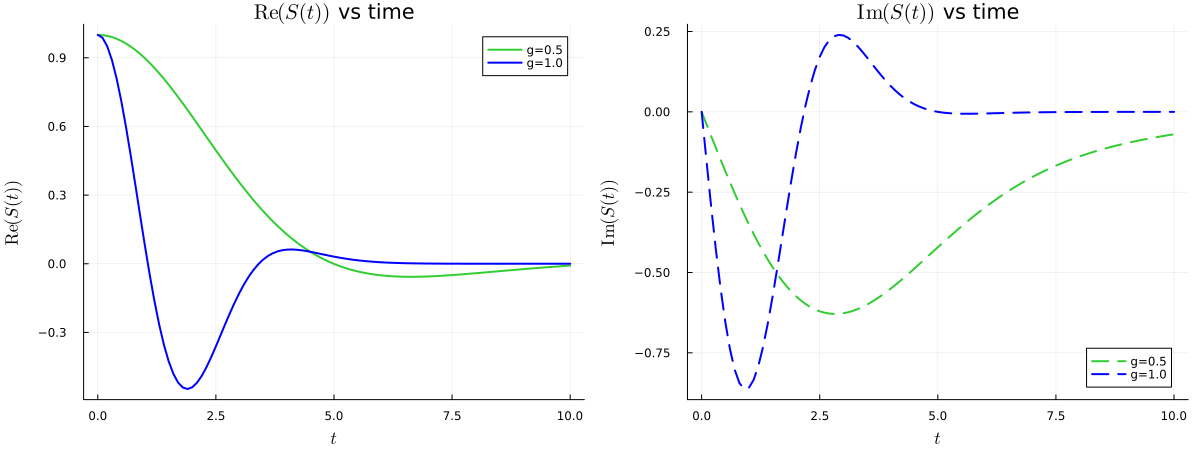

In [272]:
Re_plt = plot(
    t_range,
    real(S_t_list[1]);
    label = "g=0.5",
    lw = 2,
    color = "lime green"
)

Re_plt = plot!(
    t_range,
    real(S_t_list[2]);
    label = "g=1.0",
    lw = 2,
    color = "blue"
)

Im_plt = plot(
    t_range,
    imag(S_t_list[1]);
    label = "g=0.5",
    lw = 2,
    ls = :dash,
    color = "lime green"
)

Im_plt = plot!(
    t_range,
    imag(S_t_list[2]);
    label = "g=1.0",
    lw = 2,
    ls = :dash,
    color = "blue"
)

plot(Re_plt, Im_plt, layout=(1,2), title=["\$\\mathrm{Re}(S(t))\$ vs time" "\$\\mathrm{Im}(S(t))\$ vs time"],
    guidefont=font(12),
    xlabel=["\$t\$" "\$t\$"],
    ylabel=["\$\\mathrm{Re}(S(t))\$" "\$\\mathrm{Im}(S(t))\$"],
    size=(1200, 450), 
    bottom_margin=18px,
    left_margin=22px)
#savefig("S(t) Plots/S(t), N=$N, m=23e-1, dp=417e-2")

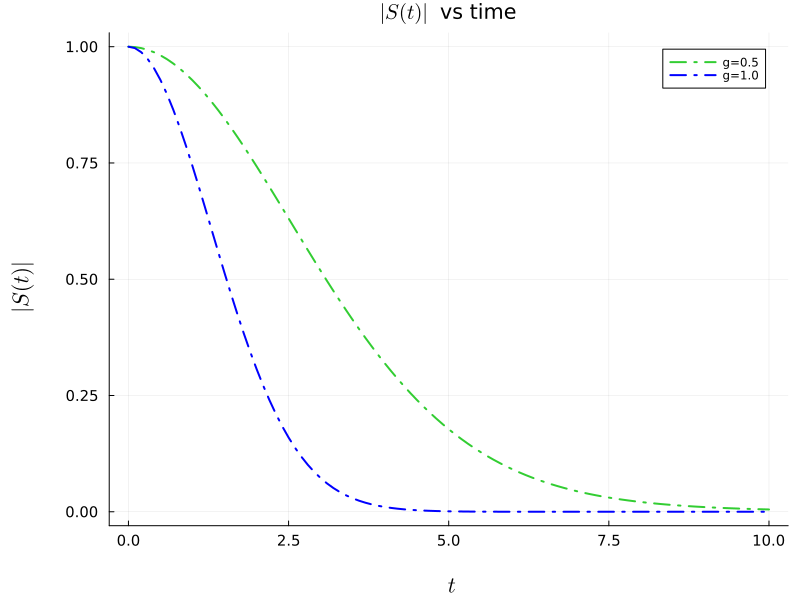

In [273]:
gr()         
default(size=(800, 600))    
plot(
    t_range,
    imag(S_t_list[1]).^2 .+ real(S_t_list[1]).^2;
    label = "g=0.5",
    lw = 2,
    ls = :dashdot,
    color = "lime green"
)

gr()         
default(size=(800, 600))    
plot!(
    t_range,
    imag(S_t_list[2]).^2 .+ real(S_t_list[2]).^2;
    label = "g=1.0",
    lw = 2,
    ls = :dashdot,
    color = "blue"
)

xlabel!("\n \$t\$", guidefont=font(15))
ylabel!("\$|S(t)|\$ \n", guidefont=font(15))
plot!(tickfontsize=10)
plot!(left_margin = 18px)
title!("\$|S(t)|\$ vs time")

#savefig("S(t) Plots/abs(S(t)), N=$N, m=23e-1, dp=417e-2")

### Calculating S(E)

In [274]:
function S(E::Real, S_t)
    dt = (2/dx)/(length(t_range)-1)
    FTSoftFunc = 0
    for t in 1:(length(t_range)-1)
        f1 = exp(im*E*t_range[t])*S_t[t]
        f2 = exp(im*E*t_range[t+1])*S_t[t+1]
        FTSoftFunc += (dt/2)*(f1+f2)
    end
    return FTSoftFunc
end

S (generic function with 1 method)

In [275]:
E_range = 0:0.05:10
S_E_list = [[S(E, S_t_list[i]) for E in E_range] for i in 1:length(g_list)]

2-element Vector{Vector{ComplexF64}}:
 [0.4693049512907994 - 0.665337913544274im, 0.6001488385526854 - 0.6225795425088916im, 0.7209011035515326 - 0.546414411448244im, 0.8217939029947617 - 0.44095935264529107im, 0.8950034595348948 - 0.31335395676793437im, 0.9355830034142185 - 0.172835246744969im, 0.9419655544293363 - 0.029543320523758656im, 0.9159730228095397 + 0.10674815482456883im, 0.862352528365049 + 0.2277769819045415im, 0.7879386636791791 + 0.3276429865535221im  …  -0.000608123735006767 + 0.019080506556739193im, 3.452220642974563e-5 + 0.018814906888582568im, 0.00066106012245962 + 0.01887457649329978im, 0.0011191313495119996 + 0.019210437449343712im, 0.0012992117363669273 + 0.019707066666290154im, 0.0011607595620352334 + 0.020211578470773938im, 0.000741263002395091 + 0.020571280436816428im, 0.00014618905851974712 + 0.020670834783797252im, -0.000477493563676166 + 0.020459888070103308im, -0.0009775800846492627 + 0.019964558133437744im]
 [0.0020196007193299757 - 0.16103384396949325im, 

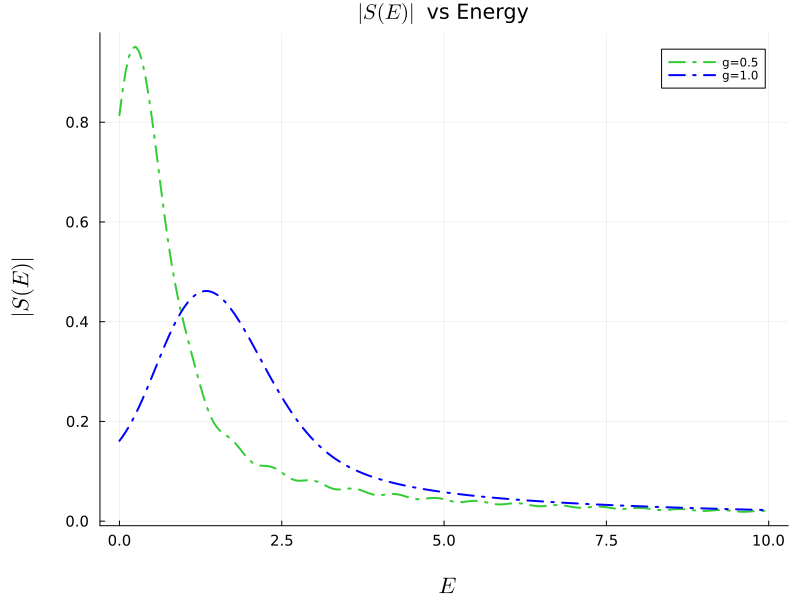

In [276]:
gr()
default(size=(800, 600))
plot(E_range, [abs(S_E_list[1][i]) for i in 1:length(E_range)], linewidth=2, label="g=0.5", linestyle=:dashdot, color="lime green")
plot!(E_range, [abs(S_E_list[2][i]) for i in 1:length(E_range)], linewidth=2, label="g=1.0", linestyle=:dashdot, color="blue")

xlabel!("\n \$E\$", guidefont=font(15))
ylabel!("\$|S(E)|\$ \n", guidefont=font(15))
plot!(tickfontsize=10)
plot!(left_margin = 18px)
title!("\$|S(E)|\$ vs Energy")

#savefig("S(E) Plots/abs(S(E)), N=$N, m=23e-1, dp=417e-2")

### Reproducing the results of 2102.05044 with N=101

In [15]:
N = 101 #Number of lattice sites per dimension

n_0 = round(Int, ((N-1)/2)) #Index of thepoint at the center of the lattice.
dp = (2*pi)/(N*dx) #Discrete change in momentum

Delta = 1/2
mass = 0
p_i = [(2pi*(s+Delta))/(N*dx) for s in 0:N-1]
om_i = [sqrt(((2/dx)*sin(p_i[i]*(dx/2)))^2 + mass^2) for i in 1:N]

H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
for i in 1:N
    H += (om_i[i]*dp)/(2pi), "a", i, "a†", i
    H += (om_i[i]*dp)/(2pi)*(1/2)*(2pi/dp), "Id", i
end

sites = siteinds("Boson", N; dim=9) #Create ITensor "SFT" sites

psi00000 = MPS(sites, MakeState(Dict()))
psi10000 = MPS(sites, MakeState(Dict(1=>"1")))
psi10001 = MPS(sites, MakeState(Dict(1=>"1", N=>"1")))

MPS
[1] ((dim=9|id=2|"Boson,Site,n=1"), (dim=1|id=649|"Link,l=1"))
[2] ((dim=1|id=649|"Link,l=1"), (dim=9|id=577|"Boson,Site,n=2"), (dim=1|id=764|"Link,l=2"))
[3] ((dim=1|id=764|"Link,l=2"), (dim=9|id=678|"Boson,Site,n=3"), (dim=1|id=617|"Link,l=3"))
[4] ((dim=1|id=617|"Link,l=3"), (dim=9|id=995|"Boson,Site,n=4"), (dim=1|id=415|"Link,l=4"))
[5] ((dim=1|id=415|"Link,l=4"), (dim=9|id=305|"Boson,Site,n=5"), (dim=1|id=16|"Link,l=5"))
[6] ((dim=1|id=16|"Link,l=5"), (dim=9|id=706|"Boson,Site,n=6"), (dim=1|id=360|"Link,l=6"))
[7] ((dim=1|id=360|"Link,l=6"), (dim=9|id=745|"Boson,Site,n=7"), (dim=1|id=819|"Link,l=7"))
[8] ((dim=1|id=819|"Link,l=7"), (dim=9|id=371|"Boson,Site,n=8"), (dim=1|id=483|"Link,l=8"))
[9] ((dim=1|id=483|"Link,l=8"), (dim=9|id=629|"Boson,Site,n=9"), (dim=1|id=750|"Link,l=9"))
[10] ((dim=1|id=750|"Link,l=9"), (dim=9|id=565|"Boson,Site,n=10"), (dim=1|id=435|"Link,l=10"))
[11] ((dim=1|id=435|"Link,l=10"), (dim=9|id=126|"Boson,Site,n=11"), (dim=1|id=961|"Link,l=11"))
[12] ((d

In [16]:
g_list = range(0, stop=0.06, length=31)
ITensors.set_warn_order(N)
ITensors.set_warn_order(N)

101

In [17]:
exp_val_list_00000 = []
exp_val_list_10000 = []
exp_val_list_10001 = []
for g in g_list
    Psi = tdvp(YnbdYn(g), 1, psi00000; nsteps=1, maxdim=500, cutoff=1e-15) #Note that the operators are completely out of order. Itensor is able to handle the operators regardless of how they are ordered.
    normalize!(Psi)

    exp_val_00000 = abs2(inner(psi00000, Psi))
    exp_val_10000 = abs2(inner(psi10000, Psi))
    exp_val_10001 = abs2(inner(psi10001, Psi))
    push!(exp_val_list_00000, exp_val_00000)
    push!(exp_val_list_10000, exp_val_10000)
    push!(exp_val_list_10001, exp_val_10001)
end

In [18]:
analytic_00000 = [1.000000000000000000e+00, 9.908232690580748292e-01, 9.637952664909003042e-01, 9.203770382643921000e-01,
 8.628576543282623357e-01, 7.941543723344067773e-01, 7.175680628197959043e-01, 6.365223615483031061e-01,
 5.543149913457101619e-01, 4.739057492787654979e-01, 3.977587345319131829e-01, 3.277478621707901052e-01,
 2.651260517527713745e-01, 2.105510132192215111e-01, 1.641552063982073262e-01, 1.256447602092179150e-01,
 9.441184759630143197e-02, 6.964677416800643672e-02, 5.043916749037805070e-02, 3.586139736730002692e-02,
 2.503104039189176996e-02, 1.715232465794841801e-02, 1.153876876487479157e-02, 7.620585614950455174e-03,
 4.940940425370784171e-03, 3.145019067826486815e-03, 1.965302210993053692e-03, 1.205668174349711769e-03,
 7.261371327676177179e-04, 4.293405313279478452e-04, 2.492169216752571320e-04]

analytic_10000 = [0.000000000000000000e+00, 2.260610607271971127e-03, 8.795779714536123076e-03, 1.889895750663164731e-02,
 3.149841513584319963e-02, 4.529752817617135885e-02, 5.893796895637732486e-02, 7.116055215259625699e-02,
 8.094055201733692251e-02, 8.758032654955788532e-02, 9.075055486663341497e-02, 9.048046038224337451e-02,
 8.710527581914363771e-02, 8.118459044467558894e-02, 7.340747682520110118e-02, 6.449951719250751614e-02,
 5.514371561822246220e-02, 4.592280556378730560e-02, 3.728571570543796898e-02, 2.953683615438552554e-02,
 2.284380562630774006e-02, 1.725802690344005116e-02, 1.274190596606940631e-02, 9.197580179584077115e-03,
 6.493243130391545756e-03, 4.484694500286589072e-03, 3.031137255717954778e-03, 2.005325559409066455e-03,
 1.298865772584815960e-03, 8.238107390298614113e-04, 5.117402778274473575e-04]

analytic_10001 = [0.000000000000000000e+00, 5.157691060857568287e-06, 8.027196592106829989e-05, 3.880698670090713628e-04,
 1.149842214521814687e-03, 2.583711845392962919e-03, 4.840912471846199432e-03, 7.955453709976306395e-03,
 1.181886303483585011e-02, 1.618531450652484563e-02, 2.070517249179603531e-02, 2.497869446579800701e-02,
 2.861781792233743585e-02, 3.130328192155173300e-02, 3.282660216557857502e-02, 3.311071397756007451e-02,
 3.220813329684790727e-02, 3.027999639670549484e-02, 2.756240169768733525e-02, 2.432768252378595189e-02,
 2.084769339677796859e-02, 1.736438054545794141e-02, 1.407049321781910813e-02, 1.110091604953737654e-02,
 8.533235117323368160e-03, 6.395027924202789128e-03, 4.675002659442777445e-03, 3.335354357668263506e-03,
 2.323324643600392907e-03, 1.580712940475981123e-03, 1.050803894817992383e-03]

31-element Vector{Float64}:
 0.0
 5.157691060857568e-6
 8.02719659210683e-5
 0.00038806986700907136
 0.0011498422145218147
 0.002583711845392963
 0.004840912471846199
 0.007955453709976306
 0.01181886303483585
 0.016185314506524846
 0.020705172491796035
 0.024978694465798007
 0.028617817922337436
 ⋮
 0.024327682523785952
 0.02084769339677797
 0.01736438054545794
 0.014070493217819108
 0.011100916049537377
 0.008533235117323368
 0.006395027924202789
 0.0046750026594427774
 0.0033353543576682635
 0.002323324643600393
 0.0015807129404759811
 0.0010508038948179924

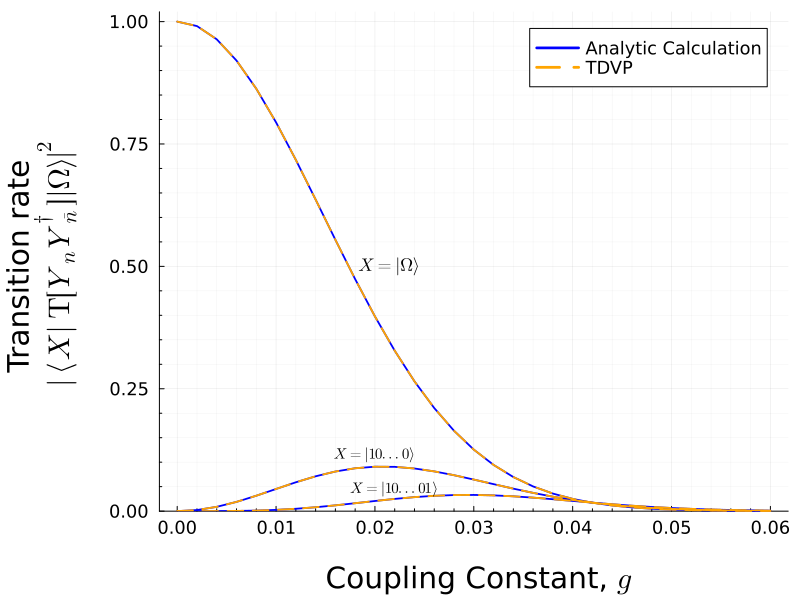

In [19]:
gr()
default(size=(800, 600))
plot(g_list, analytic_00000, linewidth=1.8, label="Analytic Calculation", color="blue")
plot!(g_list, analytic_10000, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_10001, linewidth=1.8, label="", color="blue")

plot!(g_list, exp_val_list_00000, linewidth=1.9, label="TDVP", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_10000, linewidth=1.9, label="", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_10001, linewidth=1.9, label="", linestyle=:dash, color="orange")

# Add text annotations
annotate!(0.0215, 0.5, text("\$X = |\\Omega\\rangle\$", 12))
annotate!(0.020, 0.115, text("\$X = |10...0\\rangle\$", 10))
annotate!(0.022, 0.045, text("\$X = |10...01\\rangle\$", 10))

# Axis labels with larger font via `guidefont`
xlabel!("\n Coupling Constant, \$g\$", guidefont=font(20))
ylabel!("Transition rate \n \$|\\langle X | \\mathrm{T}[Y_{n}Y_{\\bar{n}}^\\dag] | \\Omega\\rangle|^2\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Set y-limits
ylims!(0, 1.02)

# Add legend
plot!(legend=:topright, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("Transition Rates, N=101 (TDVP)")